In [1]:
!cp /kaggle/input/datasets-wheel/datasets-2.14.4-py3-none-any.whl /kaggle/working
!pip install  /kaggle/working/datasets-2.14.4-py3-none-any.whl
!cp /kaggle/input/backup-806/util_openbook.py .

Processing ./datasets-2.14.4-py3-none-any.whl
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0


In [2]:
# installing offline dependencies
!pip install -U /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!cp -rf /kaggle/input/sentence-transformers-222/sentence-transformers /kaggle/working/sentence-transformers
!pip install -U /kaggle/working/sentence-transformers
!pip install -U /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl

!pip install --no-index --no-deps /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/trl-0.5.0-py3-none-any.whl

Processing /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./sentence-transformers
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126134 sha256=461af6d419d7285fb3124d5ed7fdce24f34c09bdd2c1141ec2fd6e5f3d3b3ae9
  Stored in directory: /root/.cache/pip/wheels/6c/ea/76/d9a930b223b1d3d5d6aff69458725316b0fe205b854faf1812
Successfully built sentence-transformers
Processing /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl
Processing /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
Processing /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
Processing /kaggle/input/llm-whls/trl-0.5.0-py3-none-any.whl


In [3]:
from util_openbook import get_contexts, generate_openbook_output
import pickle

get_contexts()
generate_openbook_output()

import gc
gc.collect()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3545 [00:00<?, ?it/s]

  0%|          | 0/3545 [00:00<?, ?it/s]

Batches:   0%|          | 0/10454 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


22

In [4]:
import pandas as pd
backup_model_predictions = pd.read_csv("submission_backup.csv")

In [5]:
import numpy as np
import pandas as pd 
from datasets import load_dataset, load_from_disk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import LongformerTokenizer, LongformerForMultipleChoice
import transformers
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import unicodedata

import os

In [6]:
!cp -r /kaggle/input/stem-wiki-cohere-no-emb /kaggle/working
!cp -r /kaggle/input/all-paraphs-parsed-expanded /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]

def get_relevant_documents_parsed(df_valid):
    df_chunk_size=600
    paraphs_parsed_dataset = load_from_disk("/kaggle/working/all-paraphs-parsed-expanded")
    modified_texts = paraphs_parsed_dataset.map(lambda example:
                                             {'temp_text':
                                              f"{example['title']} {example['section']} {example['text']}".replace('\n'," ").replace("'","")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         paraphs_parsed_dataset[idx.item()]["title"],
                         paraphs_parsed_dataset[idx.item()]["text"],
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def get_relevant_documents(df_valid):
    df_chunk_size=800
    
    cohere_dataset_filtered = load_from_disk("/kaggle/working/stem-wiki-cohere-no-emb")
    modified_texts = cohere_dataset_filtered.map(lambda example:
                                             {'temp_text':
                                              unicodedata.normalize("NFKD", f"{example['title']} {example['text']}").replace('"',"")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         cohere_dataset_filtered[idx.item()]["title"],
                         unicodedata.normalize("NFKD", cohere_dataset_filtered[idx.item()]["text"]),
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def retrieval(df_valid, modified_texts):
    
    corpus_df_valid = df_valid.apply(lambda row:
                                     f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    vectorizer1 = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words)
    vectorizer1.fit(corpus_df_valid)
    vocab_df_valid = vectorizer1.get_feature_names_out()
    vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words,
                                 vocabulary=vocab_df_valid)
    vectorizer.fit(modified_texts[:500000])
    corpus_tf_idf = vectorizer.transform(corpus_df_valid)
    
    print(f"length of vectorizer vocab is {len(vectorizer.get_feature_names_out())}")

    chunk_size = 100000
    top_per_chunk = 10
    top_per_query = 10

    all_chunk_top_indices = []
    all_chunk_top_values = []

    for idx in tqdm(range(0, len(modified_texts), chunk_size)):
        wiki_vectors = vectorizer.transform(modified_texts[idx: idx+chunk_size])
        temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
        chunk_top_indices = temp_scores.argpartition(-top_per_chunk, axis=1)[:, -top_per_chunk:]
        chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

        all_chunk_top_indices.append(chunk_top_indices + idx)
        all_chunk_top_values.append(chunk_top_values)

    top_indices_array = np.concatenate(all_chunk_top_indices, axis=1)
    top_values_array = np.concatenate(all_chunk_top_values, axis=1)
    
    merged_top_scores = np.sort(top_values_array, axis=1)[:,-top_per_query:]
    merged_top_indices = top_values_array.argsort(axis=1)[:,-top_per_query:]
    articles_indices = top_indices_array[np.arange(top_indices_array.shape[0])[:, np.newaxis], merged_top_indices]
    
    return articles_indices, merged_top_scores


def prepare_answering_input(
        tokenizer, 
        question,  
        options,   
        context,   
        max_seq_length=4096,
    ):
    c_plus_q   = context + ' ' + tokenizer.bos_token + ' ' + question
    c_plus_q_4 = [c_plus_q] * len(options)
    tokenized_examples = tokenizer(
        c_plus_q_4, options,
        max_length=max_seq_length,
        padding="longest",
        truncation=False,
        return_tensors="pt",
    )
    input_ids = tokenized_examples['input_ids'].unsqueeze(0)
    attention_mask = tokenized_examples['attention_mask'].unsqueeze(0)
    example_encoded = {
        "input_ids": input_ids.to(model.device.index),
        "attention_mask": attention_mask.to(model.device.index),
    }
    return example_encoded


In [8]:
stop_words = ['each', 'you', 'the', 'use', 'used',
                  'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
                  'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
                  'his', 'their', 'then', 'been', 'myself', 're', 'not',
                  'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
                  'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
                  "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
                  'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
                  'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
                  'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
                  'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
                  'having', 'him', "haven't", 'against', 'itself', 'that',
                  'did', 'theirs', 'can', 'those',
                  'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
                  'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
                  'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
                  'yours', 'but', 'being', "wasn't", 'be']

In [9]:
df_valid = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv")

In [10]:
retrieved_articles_parsed = get_relevant_documents_parsed(df_valid)
gc.collect()

Map (num_proc=2):   0%|          | 0/2101279 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'd', 'doesn', 'don', 'isn', 'll', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won'] not in stop_words.
  warnings.warn(


length of vectorizer vocab is 11222



100%|██████████| 1/1 [05:18<00:00, 318.41s/it]


18

In [11]:
retrieved_articles = get_relevant_documents(df_valid)
gc.collect()

Map (num_proc=2):   0%|          | 0/2781652 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'd', 'doesn', 'don', 'isn', 'll', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won'] not in stop_words.
  warnings.warn(


length of vectorizer vocab is 11222



100%|██████████| 1/1 [04:18<00:00, 258.06s/it]


18

In [12]:
tokenizer = LongformerTokenizer.from_pretrained("/kaggle/input/longformer-race-model/longformer_qa_model")
model = LongformerForMultipleChoice.from_pretrained("/kaggle/input/longformer-race-model/longformer_qa_model").cuda()

In [13]:
predictions = []
submit_ids = []

for index in tqdm(range(df_valid.shape[0])):
    columns = df_valid.iloc[index].values
    submit_ids.append(columns[0])
    question = columns[1]
    options = [columns[2], columns[3], columns[4], columns[5], columns[6]]
    context1 = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
    context2 = f"{retrieved_articles_parsed[index][-3][2]}\n{retrieved_articles_parsed[index][-2][2]}\n{retrieved_articles_parsed[index][-1][2]}"
    inputs1 = prepare_answering_input(
        tokenizer=tokenizer, question=question,
        options=options, context=context1,
        )
    inputs2 = prepare_answering_input(
        tokenizer=tokenizer, question=question,
        options=options, context=context2,
        )
    
    with torch.no_grad():
        outputs1 = model(**inputs1)    
        losses1 = -outputs1.logits[0].detach().cpu().numpy()
        probability1 = torch.softmax(torch.tensor(-losses1), dim=-1)
        
    with torch.no_grad():
        outputs2 = model(**inputs2)
        losses2 = -outputs2.logits[0].detach().cpu().numpy()
        probability2 = torch.softmax(torch.tensor(-losses2), dim=-1)
        
    probability_ = (probability1 + probability2)/2

    if probability_.max() > 0.4:
        predict = np.array(list("ABCDE"))[np.argsort(probability_)][-3:].tolist()[::-1]
    else:
        predict = backup_model_predictions.iloc[index].prediction.replace(" ","")
    predictions.append(predict)

predictions = [" ".join(i) for i in predictions]

100%|██████████| 200/200 [04:44<00:00,  1.42s/it]


In [14]:
pd.DataFrame({'id':submit_ids,'prediction':predictions}).to_csv('submission.csv', index=False)

AUC-ROC Score: 0.9587
Mean Average Precision: 0.8880
Logarithmic Loss: 2.3428
F1 Score: 0.9349
Cohen's Kappa: 0.9183


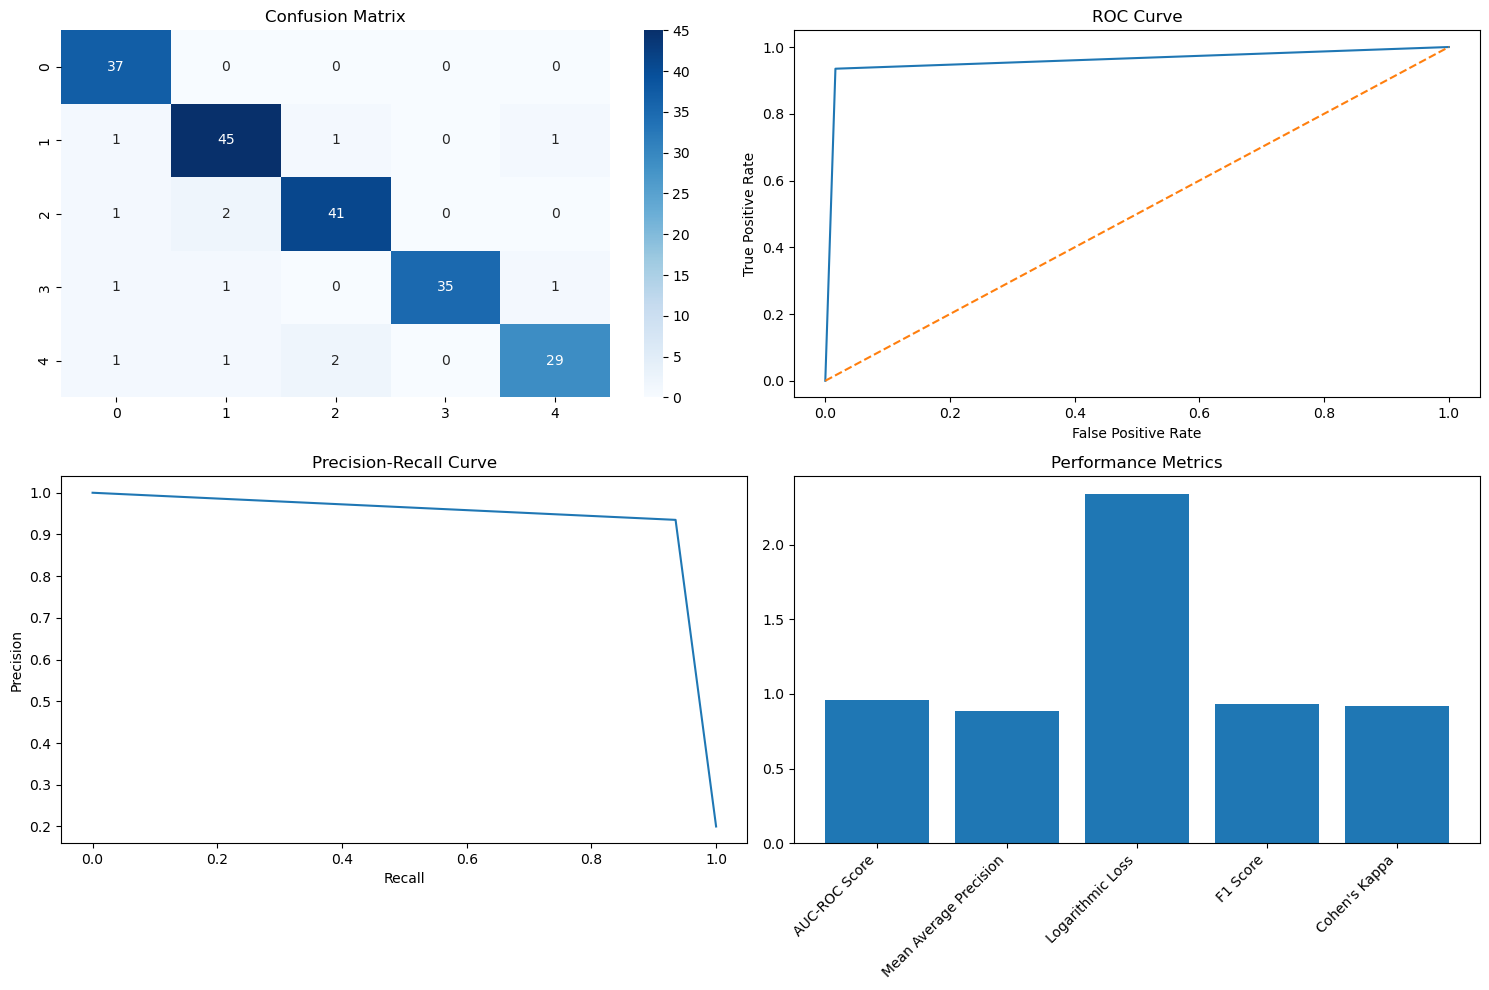

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    log_loss, 
    f1_score, 
    cohen_kappa_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# Read train and submission files
train_df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv')
submission_df = pd.read_csv('/kaggle/working/submission.csv')

# Prepare ground truth and predictions
true_labels = train_df['answer']
pred_labels = submission_df['prediction'].str.split().str[0]

# One-hot encode ground truth
true_one_hot = pd.get_dummies(true_labels)

# One-hot encode predictions
pred_one_hot = pd.get_dummies(pred_labels)

# Align dataframes
true_one_hot, pred_one_hot = true_one_hot.align(pred_one_hot, join='outer', fill_value=0)

# Metrics Calculation
metrics = {
    "AUC-ROC Score": roc_auc_score(true_one_hot, pred_one_hot, average='macro'),
    "Mean Average Precision": average_precision_score(true_one_hot, pred_one_hot, average='macro'),
    "Logarithmic Loss": log_loss(true_labels, pred_one_hot),
    "F1 Score": f1_score(true_labels, pred_labels, average='weighted'),
    "Cohen's Kappa": cohen_kappa_score(true_labels, pred_labels)
}

# Print Metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Plotting
plt.figure(figsize=(15,10))

# 1. Confusion Matrix
plt.subplot(2,2,1)
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

# 2. ROC Curve
plt.subplot(2,2,2)
fpr, tpr, _ = roc_curve(true_one_hot.values.ravel(), pred_one_hot.values.ravel())
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 3. Precision-Recall Curve
plt.subplot(2,2,3)
precision, recall, _ = precision_recall_curve(true_one_hot.values.ravel(), pred_one_hot.values.ravel())
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# 4. Performance Bar Plot
plt.subplot(2,2,4)
plt.bar(metrics.keys(), metrics.values())
plt.title('Performance Metrics')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()